# Snow fly thermal and kinematic tracking analysis code

This code is used to determine the body velocity and trajectory of representative snow flies during cooling trials, as well as, their body temperature. Additionally, this code determines the error between the temperature of snow flies captured by the FLIR camera and that recorded with a thermocouple probe. Finally, the code was used to estimate the effect size of the super cooling point (SCP) between different groups of flies. 

### Brandon and Dominic, 05/04/2023

In [98]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sea
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cmx
import io
import os
import os.path
from os import listdir
from os.path import isfile, join
import sys
import cv2
import h5py
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from scipy import interpolate
from PIL import Image
import json
import ptitprince as pt

### Manual Tracking and Kinematic and Thermal Analysis

In [2]:
tracking_data = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/snow_fly_manual_tracking/via_project_10Mar2023_19h41m_csv.csv'
temp_data_path = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/snow_fly_manual_tracking/downsampled_temp_map/'
save_path = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/snow_fly_manual_tracking/figures/'

In [3]:
# get temp file names
temp_files = []
for file in os.listdir(temp_data_path):
    if file.endswith(".csv"):
        temp_files.append(file)
    
temp_fn = []
for j in range(len(temp_files)):
    curr_file = temp_files[j][0:-4]
    for i in range(len(curr_file)):
        try:
            int_val = int(curr_file[-(i+1)::])
        except:
            temp_fn.append(int(curr_file[-(i)::]))
            break
            
# resort files
sort_idxs = np.argsort(np.array(temp_fn))
resort_temp_files = np.array(temp_files)[sort_idxs].tolist()

In [4]:
# load in manual tracking data
df_coords = pd.read_csv(tracking_data)
df_coords

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,FLIR0457_59.png,231932,{},2,0,"{""name"":""point"",""cx"":620,""cy"":15}",{}
1,FLIR0457_59.png,231932,{},2,1,"{""name"":""point"",""cx"":301,""cy"":462}",{}
2,FLIR0457_119.png,231881,{},2,0,"{""name"":""point"",""cx"":620,""cy"":15}",{}
3,FLIR0457_119.png,231881,{},2,1,"{""name"":""point"",""cx"":303,""cy"":460}",{}
4,FLIR0457_179.png,231313,{},2,0,"{""name"":""point"",""cx"":620,""cy"":15}",{}
...,...,...,...,...,...,...,...
1495,FLIR0457_44879.png,207510,{},2,1,"{""name"":""point"",""cx"":292,""cy"":115}",{}
1496,FLIR0457_44939.png,207348,{},2,0,"{""name"":""point"",""cx"":620,""cy"":15}",{}
1497,FLIR0457_44939.png,207348,{},2,1,"{""name"":""point"",""cx"":292,""cy"":115}",{}
1498,FLIR0457_44999.png,205321,{},2,0,"{""name"":""point"",""cx"":620,""cy"":15}",{}


In [5]:
# convert data into physical units [mm]
diameter_ring_mm = 70 #[mms]
diameter_ring_px = 600 # [pixels] # adjusted for the actual size of the images
conversion = diameter_ring_mm/diameter_ring_px

In [6]:
# get fly temp and cold plate temp
cold_plate_coords = df_coords['region_shape_attributes'][0::2].values
fly_coords = df_coords['region_shape_attributes'][1::2].values
pixel_boundary = 3
cold_plate_coordinates = np.zeros((len(cold_plate_coords),6))
fly_coordinates = np.zeros((len(fly_coords),6))
t=0
for j in range(len(cold_plate_coords)):
    
    t += 2 # 1 frame every 2 seconds
    
    # load corresponding temperature data
    temp_data = np.loadtxt(temp_data_path+resort_temp_files[j], delimiter=",")
    
    # cold plate info
    cold_plate_coordinates[j,0] = int(json.loads(cold_plate_coords[j])['cx'])
    cold_plate_coordinates[j,1] = int(json.loads(cold_plate_coords[j])['cy'])
    cold_plate_coordinates[j,2] = temp_data[int(cold_plate_coordinates[j,1]), int(cold_plate_coordinates[j,0])]
    cold_plate_coordinates[j,3] = int(json.loads(cold_plate_coords[j])['cx']) * conversion # mm
    cold_plate_coordinates[j,4] = int(json.loads(cold_plate_coords[j])['cy']) * conversion # mm
    cold_plate_coordinates[j,5] = t # time
    
    
    
    # fly temperature
    fly_coordinates[j,0] = int(json.loads(fly_coords[j])['cx'])
    fly_coordinates[j,1] = int(json.loads(fly_coords[j])['cy'])
    fly_coordinates[j,2] = np.min(temp_data[int(fly_coordinates[j,1])-pixel_boundary:int(fly_coordinates[j,1])+pixel_boundary, int(fly_coordinates[j,0])-pixel_boundary:int(fly_coordinates[j,0])+pixel_boundary])
#     fly_coordinates[j,2] = np.max(temp_data[int(fly_coordinates[j,1])-pixel_boundary:int(fly_coordinates[j,1])+pixel_boundary, int(fly_coordinates[j,0])-pixel_boundary:int(fly_coordinates[j,0])+pixel_boundary])
    fly_coordinates[j,3] = int(json.loads(fly_coords[j])['cx']) * conversion # mm
    fly_coordinates[j,4] = int(json.loads(fly_coords[j])['cy']) * conversion # mm
    fly_coordinates[j,5] = t # time
    
    
    

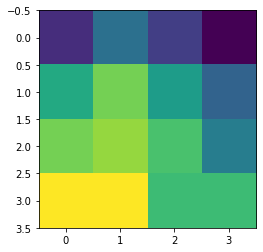

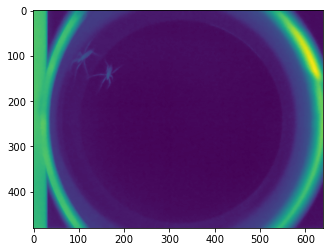

In [140]:
j = 350
pixel_boundary = 2
temp_data= np.loadtxt(temp_data_path+resort_temp_files[j], delimiter=",")
plt.figure(1)
plt.imshow(temp_data[int(fly_coordinates[j,1])-pixel_boundary:int(fly_coordinates[j,1])+pixel_boundary, int(fly_coordinates[j,0])-pixel_boundary:int(fly_coordinates[j,0])+pixel_boundary])

plt.figure(2)
plt.imshow(temp_data)

#### Fly internal and cold plate temperature

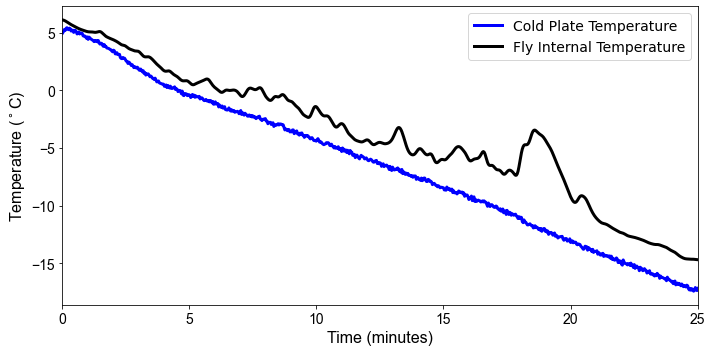

In [10]:
fig = plt.figure(1, figsize = [10,5])
plt.plot(cold_plate_coordinates[:,5]*(1/60), cold_plate_coordinates[:,2], color ='blue', linewidth = 3)
plt.plot(cold_plate_coordinates[:,5]*(1/60), filt_temp, color = 'black', linewidth = 3)
plt.xlim([0,25])
plt.ylabel('Temperature ($^\circ$C)', fontsize = 16, fontname = 'Arial')
plt.xlabel('Time (minutes)', fontsize = 16, fontname = 'Arial')
plt.yticks(fontsize = 14, fontname = 'Arial')
plt.xticks(fontsize = 14, fontname = 'Arial')
plt.legend(['Cold Plate Temperature', 'Fly Internal Temperature'], fontsize = 14, loc ='best')
plt.tight_layout()
plt.show()
fig.savefig(save_path + 'cold_plate_fly_temp.png', dpi = 300)
fig.savefig(save_path + 'cold_plate_fly_temp.pdf', dpi = 300)

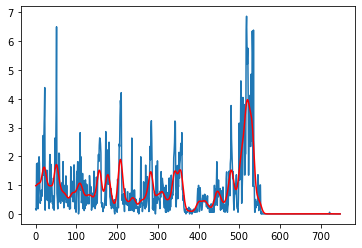

In [11]:
# calculate instaneous velocity
dt = 2 # 2 seconds per frame
instanteous_vel = (np.sqrt(np.diff(fly_coordinates[:,3])**2 +np.diff(fly_coordinates[:,4])**2 )/dt)
filt_vel = gaussian_filter1d(instanteous_vel, 5) # filter velocity with a guassian kernel

plt.plot(instanteous_vel)
plt.plot(filt_vel, color = 'red')

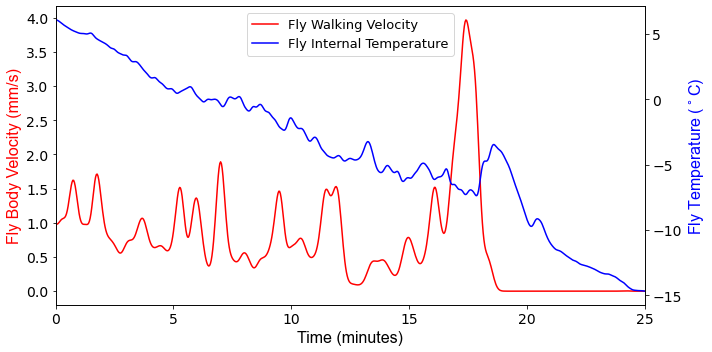

In [12]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize =[10,5])

# make a plot
plt1 = ax.plot((fly_coordinates[:,5]*(1/60))[1::], filt_vel, color="red", label ='Fly Walking Velocity')
# set x-axis label
ax.set_xlabel("Time (minutes)", fontsize = 16, fontname = 'Arial')
# set y-axis label
ax.set_ylabel("Fly Body Velocity (mm/s)",color="red",fontsize=16, fontname = 'Arial')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
plt2 = ax2.plot(fly_coordinates[:,5]*(1/60), filt_temp, color="blue", label ='Fly Internal Temperature')
ax2.set_ylabel("Fly Temperature ($^\circ$C)",color="blue",fontsize=16, fontname = 'Arial')

ax.set_xlim([0, 25])
ax2.set_xlim([0, 25])

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# Solution for having two legends
leg = plt1 + plt2
labs = [l.get_label() for l in leg]
ax.legend(leg, labs, loc=9, fontsize = 13)

plt.tight_layout()
plt.show()

fig.savefig(save_path + 'fly_temp_velocity.png', dpi = 300)
fig.savefig(save_path + 'fly_temp_velocity.pdf', dpi = 300)

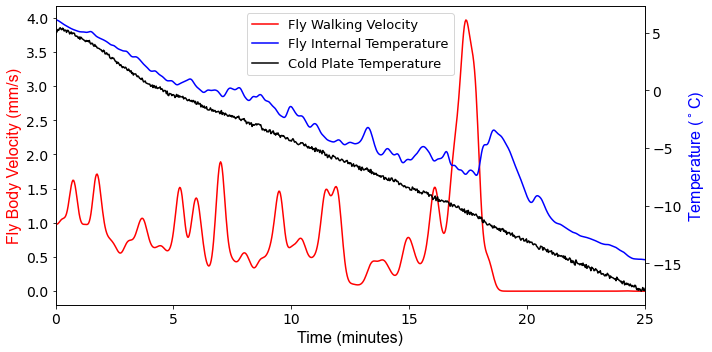

In [162]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize =[10,5])

# make a plot
plt1 = ax.plot((fly_coordinates[:,5]*(1/60))[1::], filt_vel, color="red", label ='Fly Walking Velocity', zorder = 10)
# set x-axis label
ax.set_xlabel("Time (minutes)", fontsize = 16, fontname = 'Arial')
# set y-axis label
ax.set_ylabel("Fly Body Velocity (mm/s)",color="red",fontsize=16, fontname = 'Arial')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
plt2 = ax2.plot(fly_coordinates[:,5]*(1/60), filt_temp, color="blue", label ='Fly Internal Temperature')
plt3 = ax2.plot(cold_plate_coordinates[:,5]*(1/60), cold_plate_coordinates[:,2], color="black", label ='Cold Plate Temperature')
ax2.set_ylabel("Temperature ($^\circ$C)",color="blue",fontsize=16, fontname = 'Arial')

ax.set_xlim([0, 25])
ax2.set_xlim([0, 25])

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# Solution for having two legends
leg = plt1 + plt2 + plt3
labs = [l.get_label() for l in leg]
ax.legend(leg, labs, loc=9, fontsize = 13)

plt.tight_layout()
plt.show()

fig.savefig(save_path + 'plate_fly_temp_velocity.png', dpi = 300)
fig.savefig(save_path + 'plate_fly_temp_velocity.pdf', dpi = 300)

#### unfiltered version

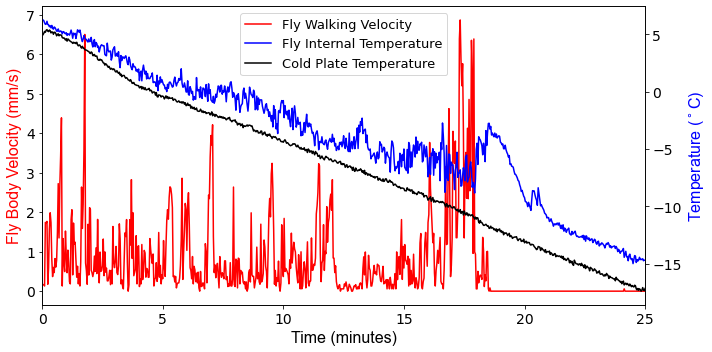

In [10]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize =[10,5])

# make a plot
plt1 = ax.plot((fly_coordinates[:,5]*(1/60))[1::], instanteous_vel, color="red", label ='Fly Walking Velocity', zorder = 10)
# set x-axis label
ax.set_xlabel("Time (minutes)", fontsize = 16, fontname = 'Arial')
# set y-axis label
ax.set_ylabel("Fly Body Velocity (mm/s)",color="red",fontsize=16, fontname = 'Arial')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
plt2 = ax2.plot(fly_coordinates[:,5]*(1/60), fly_coordinates[:,2], color="blue", label ='Fly Internal Temperature')
plt3 = ax2.plot(cold_plate_coordinates[:,5]*(1/60), cold_plate_coordinates[:,2], color="black", label ='Cold Plate Temperature')
ax2.set_ylabel("Temperature ($^\circ$C)",color="blue",fontsize=16, fontname = 'Arial')

ax.set_xlim([0, 25])
ax2.set_xlim([0, 25])

ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# Solution for having two legends
leg = plt1 + plt2 + plt3
labs = [l.get_label() for l in leg]
ax.legend(leg, labs, loc=9, fontsize = 13)

plt.tight_layout()
plt.show()

fig.savefig(save_path + 'unfiltered_plate_fly_temp_velocity.png', dpi = 300)
fig.savefig(save_path + 'unfiltered_plate_fly_temp_velocity.pdf', dpi = 300)

#### Fly Trajectory colored by time, internal temperature, and velocity

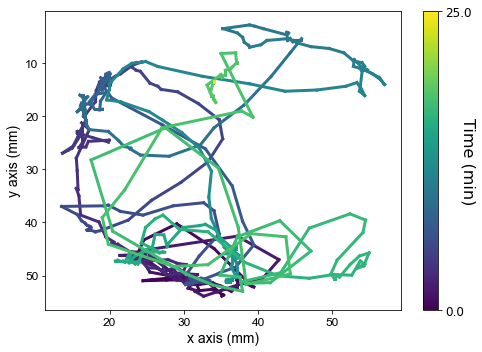

In [163]:
'''Time'''
t_min = fly_coordinates[:,5]*(1/60)
norm_t = t_min - np.min(t_min)
norm_t = norm_t/np.max(norm_t)

# convert
cmap = plt.cm.get_cmap('viridis')
# cmap = plt.cm.get_cmap('plasma')
t_cmap = cmap(norm_t)

fig = plt.figure(1, figsize = [7, 5])
for j in range(len(fly_coordinates[:,3])-1):
    plt.plot(fly_coordinates[[j,j+1],3], fly_coordinates[[j,j+1],4], c = t_cmap[j,:], linewidth = 3)
cbar = fig.colorbar(cmx.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(norm_t), vmax=max(norm_t)), cmap='viridis'), ticks=[0, 1], orientation='vertical')
# cbar = fig.colorbar(cmx.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(norm_t), vmax=max(norm_t)), cmap='plasma'), ticks=[0, 1], orientation='vertical')
cbar.ax.set_yticklabels([str(np.round(np.min(t_min),1)), str(np.round(np.max(t_min),1))], fontsize = 12)
cbar.set_label('Time (min)', rotation=270, fontsize = 16)
plt.gca().invert_yaxis()
plt.xlabel('x axis (mm)', fontsize = 14,fontname="Arial")
plt.xticks(fontsize = 12,fontname="Arial")
plt.ylabel('y axis (mm)', fontsize = 14,fontname="Arial")
plt.yticks(fontsize = 12,fontname="Arial")
plt.tight_layout()
plt.show()
fig.savefig(save_path+'_trajectory_time.png', dpi = 300)
fig.savefig(save_path+'_trajectory_time.pdf', dpi = 300)

In [23]:
from matplotlib.colors import LinearSegmentedColormap
res=50
new_colormap_half1 = np.transpose(np.vstack((np.linspace(14, 118, res),np.linspace(15, 31, res), np.linspace(27, 88, res))))/255
new_colormap_half2 = np.transpose(np.vstack((np.linspace(118, 230, res),np.linspace(31, 60, res), np.linspace(88, 64, res))))/255
new_colormap = np.concatenate((new_colormap_half1, new_colormap_half2))

In [24]:
researchir_map = LinearSegmentedColormap.from_list('newmap', new_colormap)

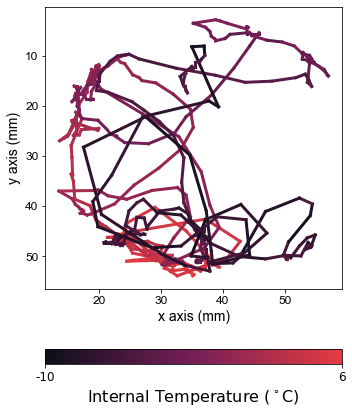

In [55]:
'''Fly Internal Temperature'''
# normalize temp
# norm_temp = adjusted_fly_data[:,2] - np.min(adjusted_fly_data[:,2])
# norm_temp = norm_temp/np.max(norm_temp)

norm_temp = adjusted_fly_data[:,2] - np.min(adjusted_fly_data[:,2])
norm_temp = norm_temp/np.max(norm_temp)


# convert
cmap = plt.cm.get_cmap(researchir_map)
temp_cmap = cmap(norm_temp)

fig = plt.figure(1, figsize = [5, 6])
for j in range(len(adjusted_fly_data[:,3])-1):
    plt.plot(fly_coordinates[[j,j+1],3], fly_coordinates[[j,j+1],4], c = temp_cmap[j,:], linewidth = 3)
cbar = fig.colorbar(cmx.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(norm_temp), vmax=max(norm_temp)), cmap=researchir_map), ticks=[0, 1], orientation='horizontal')
cbar.ax.set_xticklabels([str(-10), str(6)], fontsize = 12)
cbar.set_label('Internal Temperature ($^\circ$C)', rotation=0, fontsize = 16)
plt.gca().invert_yaxis()
plt.xlabel('x axis (mm)', fontsize = 14,fontname="Arial")
plt.xticks(fontsize = 12,fontname="Arial")
plt.ylabel('y axis (mm)', fontsize = 14,fontname="Arial")
plt.yticks(fontsize = 12,fontname="Arial")
plt.tight_layout()
plt.show()
fig.savefig(save_path+'_trajectory_internal_temperature.png', dpi = 300)
fig.savefig(save_path+'_trajectory_internal_temperature.pdf', dpi = 300)

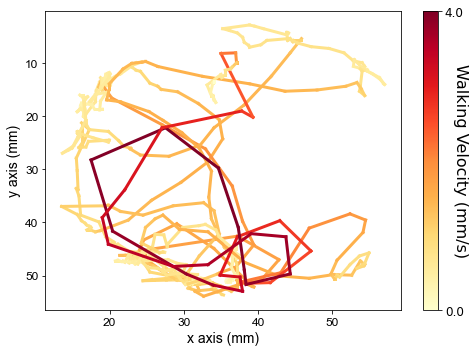

In [165]:
'''Fly Walking Velocity'''
# normalize time
norm_v = filt_vel - np.min(filt_vel)
norm_v = norm_v/np.max(norm_v)

# convert
cmap = plt.cm.get_cmap('YlOrRd')
v_cmap = cmap(norm_v)

fig = plt.figure(1, figsize = [7, 5])
for j in np.arange(1,len(fly_coordinates[:,3])-1):
    plt.plot(fly_coordinates[[j,j+1],3], fly_coordinates[[j,j+1],4], c = v_cmap[j,:], linewidth = 3)
cbar = fig.colorbar(cmx.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(norm_v), vmax=max(norm_v)), cmap='YlOrRd'), ticks=[0, 1], orientation='vertical')
cbar.ax.set_yticklabels([str(np.round(np.min(filt_vel),1)), str(np.round(np.max(filt_vel),1))], fontsize = 12)
cbar.set_label('Walking Velocity (mm/s)', rotation=270, fontsize = 16)
plt.gca().invert_yaxis()
plt.xlabel('x axis (mm)', fontsize = 14,fontname="Arial")
plt.xticks(fontsize = 12,fontname="Arial")
plt.ylabel('y axis (mm)', fontsize = 14,fontname="Arial")
plt.yticks(fontsize = 12,fontname="Arial")
plt.tight_layout()
plt.show()
fig.savefig(save_path+'_trajectory_velocity.png', dpi = 300)
fig.savefig(save_path+'_trajectory_velocity.pdf', dpi = 300)

### RMSE between FLIR temperature reading and thermocouple

In [19]:
calibration_data_path = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/snow_fly_manual_tracking/temp_calibration_files/'
cal_files = [f for f in listdir(calibration_data_path) if isfile(join(calibration_data_path, f))]
calibration_data = cal_files[0:10]
calibration_meta = cal_files[10]
meta_data = pd.read_csv(calibration_data_path + calibration_meta)
meta_trials = meta_data['trial'].values
meta_trial_dt = meta_data['delta t'].values

In [64]:
RMSE =[]
for j in range(len(meta_trials)):
    # find the corresponding data file
    for i in range(len(calibration_data)):
        if meta_trials[j] == calibration_data[i][0:6]: # adjust the two trials and find the rmse
            print(calibration_data[i])
            cal_data = pd.read_csv(calibration_data_path + calibration_data[i])
            trial_dt = meta_trial_dt[j]
            
            # adjust probe time 
            probe_time = cal_data['probe time'].values-trial_dt
            probe_temp = cal_data['probe temp'].values
            cam_time = cal_data['reltime'].values
            cam_temp = cal_data['Cursor 1 [C]'].values

            f = interpolate.interp1d(probe_time, probe_temp, fill_value = 'extrapolate')
            adj_probe_temp = f(cam_time)
            
            # calculate the RMSE  between the probe and camera temperature
            RMSE.append(np.sqrt(np.nanmean((adj_probe_temp-cam_temp)**2)))

CF0022 Combined adjusted.csv
CF0023 Combined adjusted.csv
CF0024 Combined adjusted.csv
CF0025 Combined adjusted.csv
CF0026 Combined adjusted.csv
CF0027 Combined adjusted.csv
CF0028 Combined adjusted.csv
CF0029 Combined adjusted.csv
CF0030 Combined adjusted.csv
CF0031 Combined adjusted.csv


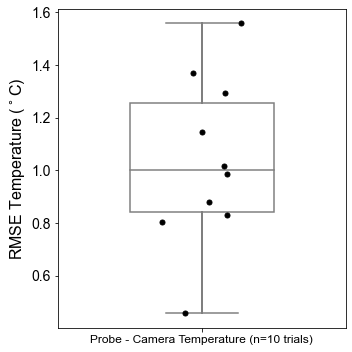

In [80]:
# plot the root mean squared error
# plot box plot
fig, ax = plt.subplots(figsize=(5, 5))
ax=sea.boxplot(data = np.array(RMSE), color = "lightgray", width = 0.5, zorder = 1,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":1},\
showfliers=False, whiskerprops = {'linewidth':2, "zorder":1},\
saturation = 1)

plt.plot(np.zeros(len(RMSE)) + np.random.choice([-1,1],size=len(RMSE))*np.random.uniform(low=0.0, high=0.15, size=len(RMSE)), np.array(RMSE), color ='black', marker = '.', markersize=10, linestyle = 'None', zorder = 10)

plt.xticks(np.array([0]), np.array(['Probe - Camera Temperature (n='+str(len(RMSE))+' trials)']), fontsize = 12, rotation = 0, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylabel('RMSE Temperature ($^\circ$C)', fontsize = 16, fontname="Arial")
plt.tight_layout()
plt.show()
fig.savefig(save_path+'_RMSE_temp.pdf', dpi = 300)
fig.savefig(save_path+'_RMSE_temp.png', dpi = 300)



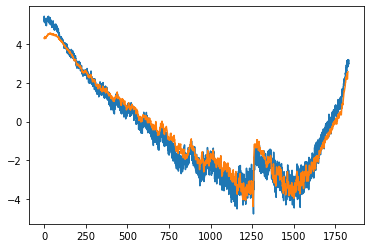

In [62]:
plt.plot(cam_time, cam_temp)
plt.plot(cam_time, adj_probe_temp)

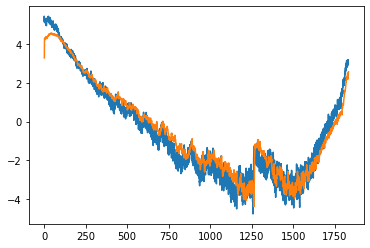

In [61]:
plt.plot(cal_data['reltime'].values, cal_data['Cursor 1 [C]'].values)
plt.plot(cal_data['probe time'].values, cal_data['probe temp'].values)

### Estimation Statistics 

In [82]:
scp_data_filename = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/Analysis/snow_fly_manual_tracking/scp_data/Snow fly (active + inactive) and crane flies temperature analysis.csv'
scp_data = pd.read_csv(scp_data_filename)
scp_data

,Ambient temp (crane fly),Ambient temp (snow fly),Ambient temp (immobilized snow fly),Fly temp pre-sc (crane fly),Fly temp pre-sc (snow fly),Fly temp pre-sc (immobilized snow fly),Fly temp post-sc (crane fly),Fly temp post-sc (snow fly),Fly temp post-sc (immobilized snow fly)
0,-11.83,-9.20,-11.75,-3.96,-7.40,-10.82,-2.80,-2.00,-2.62
1,-8.76,-8.80,-10.14,-5.78,-7.40,-8.53,-1.74,-1.20,-3.46
2,-9.68,-5.40,-11.90,-6.77,-3.90,-9.44,-1.43,-0.90,-2.42
3,-9.03,-10.20,-12.02,-5.22,-6.50,-10.64,-1.67,-1.60,-4.00
4,-11.63,-8.40,-9.29,-5.99,-6.00,-7.95,-1.80,-1.90,-1.82
...,...,...,...,...,...,...,...,...,...
69,NaN,-11.26,NaN,NaN,-8.66,NaN,NaN,-2.59,NaN
70,NaN,-12.23,NaN,NaN,-7.87,NaN,NaN,-2.23,NaN
71,NaN,-11.76,NaN,NaN,-7.42,NaN,NaN,-2.54,NaN
72,NaN,-11.54,NaN,NaN,-7.17,NaN,NaN,-2.12,NaN


In [84]:
snow_fly_active = scp_data['Fly temp pre-sc (snow fly)'].values
snow_fly_active = snow_fly_active[~np.isnan(snow_fly_active)]
snow_fly_inactive = scp_data['Fly temp pre-sc (immobilized snow fly)'].values
snow_fly_inactive = snow_fly_inactive[~np.isnan(snow_fly_inactive)]
crane_fly = scp_data['Fly temp pre-sc (crane fly)'].values
crane_fly  = crane_fly[~np.isnan(crane_fly)]

In [94]:
# estimation stats - bootstrap uniformly random sampled observations with replacement 
def estimate_effect_size(pop1, pop2):
    n_bootstraps = 1000 # number of bootstraps
    n_resamps = 100 # number of randomly chosen samples
    mean_diff = np.zeros(n_bootstraps)
    for j in range(n_bootstraps):
        pop1_dist = np.random.choice(pop1, size = n_resamps)
        pop2_dist = np.random.choice(pop2, size = n_resamps)
        mean_diff[j] = np.mean(pop1_dist) - np.mean(pop2_dist)

    sort_mean_diff = np.sort(mean_diff)
    CI_95 = sort_mean_diff[25:975]
    
    return sort_mean_diff, CI_95

In [126]:
# estimate the effect size of scp between fly groups
snowfly_cranefly_mean_diff, snowfly_cranefly_95CI = estimate_effect_size(snow_fly_active, crane_fly)
snowfly_active_inactive_mean_diff, snowfly_active_inactive_95CI = estimate_effect_size(snow_fly_active, snow_fly_inactive)

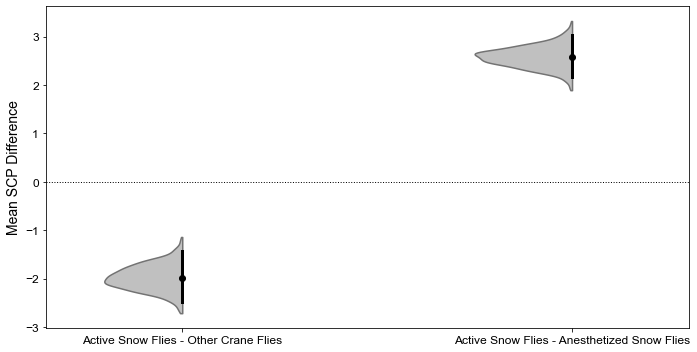

In [137]:
# plot estimation stats
cat_mean_diffs = [snowfly_cranefly_mean_diff, snowfly_active_inactive_mean_diff]
identity = [np.zeros(950), np.ones(950)]
cat_CI = [snowfly_cranefly_95CI, snowfly_active_inactive_95CI]
plot_info = ['Active Snow Flies - Other Crane Flies', 'Active Snow Flies - Anesthetized Snow Flies']

# cloud plot
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.half_violinplot(data = cat_mean_diffs, cut = 0., scale = "area", width = 0.5, inner = None, 
                      color ='silver', edgecolor="none")

ax=plt.plot(identity[0]-0.15, cat_CI[0], color = "black",linewidth = 3)
ax=plt.plot(identity[0][0]-0.15, np.mean(cat_CI[0]), color = "black", marker = '.', markersize = 12, linestyle ='none')

ax=plt.plot(identity[1]-0.15, cat_CI[1], color = "black",linewidth = 3)
ax=plt.plot(identity[1][0]-0.15, np.mean(cat_CI[1]), color = "black", marker = '.', markersize = 12, linestyle ='none')

plt.axhline(y = 0, color = 'black', linestyle = ':', linewidth = 1)
plt.xticks(np.arange(len(plot_info))-0.15, plot_info, fontsize = 12, rotation = 0, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")
plt.ylabel('Mean SCP Difference', fontsize = 14, fontname="Arial")
plt.xlim([-0.5,1.15])
plt.tight_layout()
plt.show()
f.savefig(save_path+'_estimation_plots.pdf', dpi = 300)
f.savefig(save_path+'_estimation_plots.png', dpi = 300)